In [1]:
import os

import pandas
import torch
import pickle
import training
import utilities
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import nltk
import sklearn.metrics.pairwise

In [2]:
targetColumns = ['authors', 'title', 'abstract', 'eid', 'file', 'year', 'source title']

In [5]:
df_raw = pandas.DataFrame()
for i, fname in enumerate(os.listdir('../CSS_TSS/')):
    if fname.endswith('.csv') and not fname.startswith('CSS'):
        df_file = pandas.read_csv('../CSS_TSS/{}'.format(fname))
        df_file.columns = [s.lower() for s in df_file.columns]
        df_file['file'] = i
        df_raw = df_raw.append(df_file, ignore_index=True)

In [6]:
df_tss = df_raw[targetColumns].copy()
df_tss['class'] = 0

In [8]:
df_raw = pandas.DataFrame()
for i, fname in enumerate(os.listdir('../CSS_TSS/')):
    if fname.endswith('.csv') and fname.startswith('CSS'):
        df_file = pandas.read_csv('../CSS_TSS/{}'.format(fname))
        df_file.columns = [s.lower() for s in df_file.columns]
        df_file['file'] = i
        df_raw = df_raw.append(df_file, ignore_index=True)

/Users/Reid/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
df_css = df_raw[df_raw['bitbybit']][df_raw['wos']][targetColumns].copy()
df_css['class'] = 1

/Users/Reid/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [15]:
df = df_css.append(df_tss, ignore_index=True)#.dropna()

In [5]:
df_css = pandas.read_csv('data/WoS_Related_scopus_b (1).csv')
df_css.columns = [s.lower() for s in df_css.columns]
df_css['file'] = 'tss'
df_css = df_css[targetColumns].copy()
df_css['class'] = 1

In [19]:
df = df_css.append(df_tss, ignore_index=True)#.dropna()

In [20]:
df.dropna().__len__()

92020

In [21]:
df.__len__()

92020

In [23]:
df.to_csv('data/combined.csv')

In [18]:
df = pandas.read_csv('data/combined.csv')

In [11]:
df_css.dropna().__len__()

491

In [12]:
dfY = pandas.read_csv('outputs/withYears.csv', index_col='eid')
dfY['isCSS'] = dfY['weightP'] > dfY['weightN']

In [13]:
df.index = df['eid']

In [14]:
df_j = dfY.join(df, lsuffix = '_l')

In [18]:
df_p[df_p['isCSS'] == False].iloc[2]['title']

'What to do on Spring Break? The Role of Predicted, on-Line, and Remembered Experience in Future Choice'

In [15]:
df_p = df_j[df_j['class'] == 1]
df_p[df_p['isCSS'] == False].iloc[2]['abstract']

"When individuals choose future activities on the basis of their past experiences, what guides those choices? The present study compared students' predicted, on-line, and remembered spring-break experiences, as well as the influence of these factors on students' desire to take a similar vacation in the future. Predicted and remembered experiences were both more positive - and, paradoxically, more negative - than on-line experiences. Of key importance, path analyses revealed that remembered experience, but neither on-line nor anticipated experience, directly predicted the desire to repeat the experience. These results suggest that although on-line measures may be superior to retrospective measures for approximating objective experience, retrospective measures may be superior for predicting choice."

In [19]:
df_n[df_n['isCSS']].iloc[3]['title']

"Making social science work across space and time: A critical reflection on Robert Putnam's making democracy work"

In [16]:
df_n = df_j[df_j['class'] == 0]
df_n[df_n['isCSS']].iloc[3]['abstract']

"Political scientists are becoming more self-conscious about how they connect quantitative and qualitative data in social science and about the role of systematic country studies in comparative research. As the most striking example of both practices in recent years, Robert Putnam and his collaborators' Making Democracy Work deserves more serious criticism than it has received. While Putnam's original project aimed at a precise goal - studying how a new administrative reform is institutionalized - his ultimate project aimed at nothing less than examining how differently democracy works in different sociopolitical contexts, operationalized cross-sectionally in southern and northern Italy. The sources of these differences he found in the two regions' histories, which led him to employ the quantitative interregional data he had collected for one purpose to support a model of historical development of North and South. This historical reconstruction rests largely on qualitative data; but it

In [17]:
def compareRows(rows, N, useTitle = True, w2v = None):
    fig, axes = plt.subplots(figsize = (20,25),
                             nrows = len(rows) + 1,
                             gridspec_kw = {'height_ratios': [5] * len(rows) + [1]})
    aLst = []
    for i, row in enumerate(rows):
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        out = N(abVec, tiVec)
        probNeg = np.exp(out.data[0][0])
        probPos = np.exp(out.data[0][1])            
        probNeg = probNeg / (probNeg + probPos)
        probPos = probPos / (probNeg + probPos)
        
        a = np.array(outLSTM.data.tolist())
        aLst.append(a[0, -1, :])
        #a = a[:,:100,:]
        df = pandas.DataFrame(a[0, :, :])
        df.index = nltk.word_tokenize(s)[:a.shape[1]]
        seaborn.heatmap(df, ax = axes[i], label='big')
        axes[i].set_title("Article Title: '{}'\n$P_{{negative}} = {:.4f}, P_{{positive}} = {:.4f}$".format(row['title'], probNeg, probPos), fontsize = 20)
        axes[i].set_xticklabels([])
        
    
    dfDiff = pandas.DataFrame(np.stack([aLst[0], np.fabs(aLst[0] - aLst[1]), aLst[1]]))
    dfDiff.index = ['Top', 'Diff', 'Bottom']
    seaborn.heatmap(dfDiff, ax = axes[-1], xticklabels = [i if i in np.linspace(0, len(dfDiff.columns) - 1, num = 10, dtype='int') else '' for i in range(len(dfDiff.columns))])
    axes[-1].set_title('Difference in Final Output Vectors', fontsize = 20)
    
    return fig, axes

In [60]:
with open("models/BiRNN-2-256-30.pt", 'rb') as f:
    N = torch.load(f)
N.cuda()

BiRNN-2-256-30

In [64]:
dataDir = 'data'
modelsDir = 'models'

rawFname = 'combined.csv'
manualFname = None

w2vFname = 'word2vec.bin'
pickleFname = 'dfPickles.p'
regenW2V = False
df_w2v, w2v = utilities.preprocesing(dataDir, rawFname, modelsDir, w2vFname, pickleFname)

Loading W2V
Loading DF


,Unnamed: 0,authors,title,abstract,eid,file,class,title_tokens,abstract_tokens
0,0,"Johnson H.A., Wagner M.M., Hogan W.R., Chapman...",Analysis of Web access logs for surveillance o...,The purpose of this study was to determine whe...,2-s2.0-21644487468,tss,1,"[analysis, of, web, access, logs, for, surveil...","[[the, purpose, of, this, study, was, to, dete..."
1,1,"Bazelli B., Hindle A., Stroulia E.",On the personality traits of StackOverflow users,"In the last decade, developers have been incre...",2-s2.0-84891703786,tss,1,"[on, the, personality, traits, of, stackoverfl...","[[in, the, last, decade, ,, developers, have, ..."
2,2,"Boia M., Faltings B., Musat C.-C., Pu P.",A :) Is worth a thousand words: How people att...,Emoticons are widely used to express positive ...,2-s2.0-84893608034,tss,1,"[a, :, ), is, worth, a, thousand, words, :, ho...","[[emoticons, are, widely, used, to, express, p..."
3,3,"Ofek N., Caragea C., Biyani P., Rokach L., Mit...",Improving sentiment analysis in an online canc...,Online Health Communities is a major source fo...,2-s2.0-84881186112,tss,1,"[improving, sentiment, analysis, in, an, onlin...","[[online, health, communities, is, a, major, s..."
4,4,"Costa J., Silva C., Antunes M., Ribeiro B.",Defining semantic meta-hashtags for twitter cl...,"Given the wide spread of social networks, rese...",2-s2.0-84893505918,tss,1,"[defining, semantic, meta-hashtags, for, twitt...","[[given, the, wide, spread, of, social, networ..."
5,5,"Jungherr A., Jürgens P.",Forecasting the pulse: How deviations from reg...,Purpose: The steady increase of data on human ...,2-s2.0-84885442655,tss,1,"[forecasting, the, pulse, :, how, deviations, ...","[[purpose, :, the, steady, increase, of, data,..."
6,6,Bronstein J.,Like me! Analyzing the 2012 presidential candi...,The present study aims to report the findings ...,2-s2.0-84882331984,tss,1,"[like, me, !, analyzing, the, 2012, presidenti...","[[the, present, study, aims, to, report, the, ..."
7,7,"Bonsón E., Ratkai M.",A set of metrics to assess stakeholder engagem...,Purpose - This study aims to propose a set of ...,2-s2.0-84884852538,tss,1,"[a, set, of, metrics, to, assess, stakeholder,...","[[purpose, -, this, study, aims, to, propose, ..."
8,8,"Brownstein J.S., Freifeld C.C., Madoff L.C.",Digital disease detection - Harnessing the web...,[No abstract available],2-s2.0-66149157263,tss,1,"[digital, disease, detection, -, harnessing, t...","[[[, no, abstract, available, ]]]"
9,9,"Cash S.J., Thelwall M., Peck S.N., Ferrell J.Z...",Adolescent suicide statements on MySpace,The use of social networking sites (SNSs) has ...,2-s2.0-84875207236,tss,1,"[adolescent, suicide, statements, on, myspace]","[[the, use, of, social, networking, sites, (, ..."


In [68]:
r1 = df_w2v.iloc[0]
r2 = df_w2v.iloc[-1]

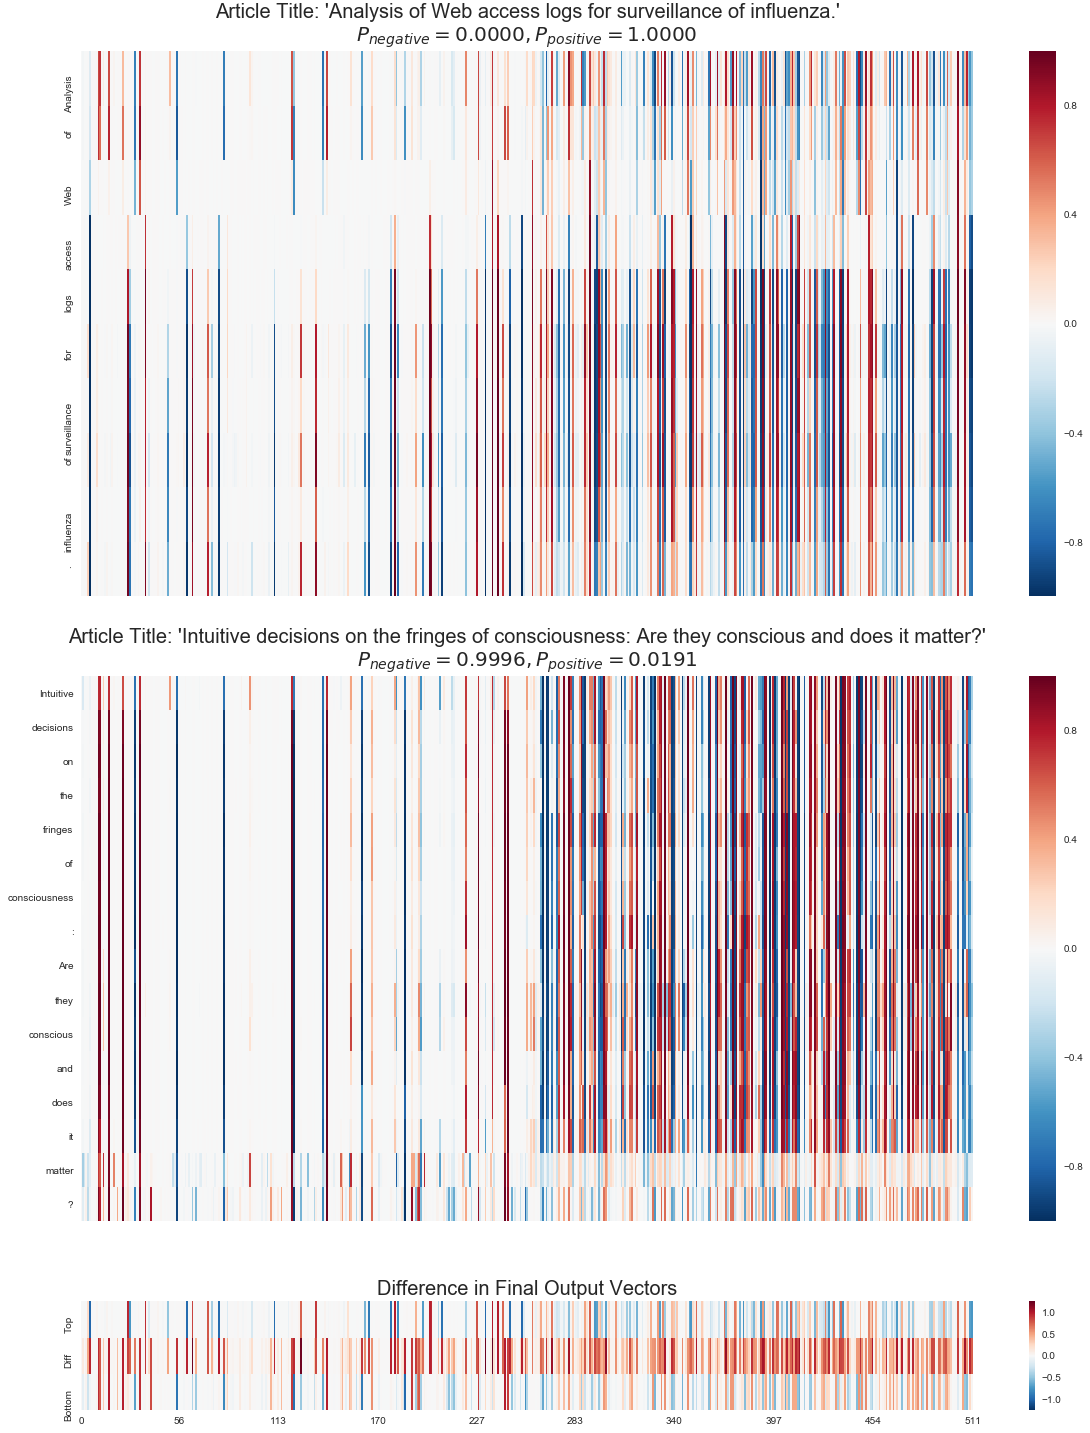

In [70]:
compareRows([r1, r2], N, w2v = w2v)
#plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()

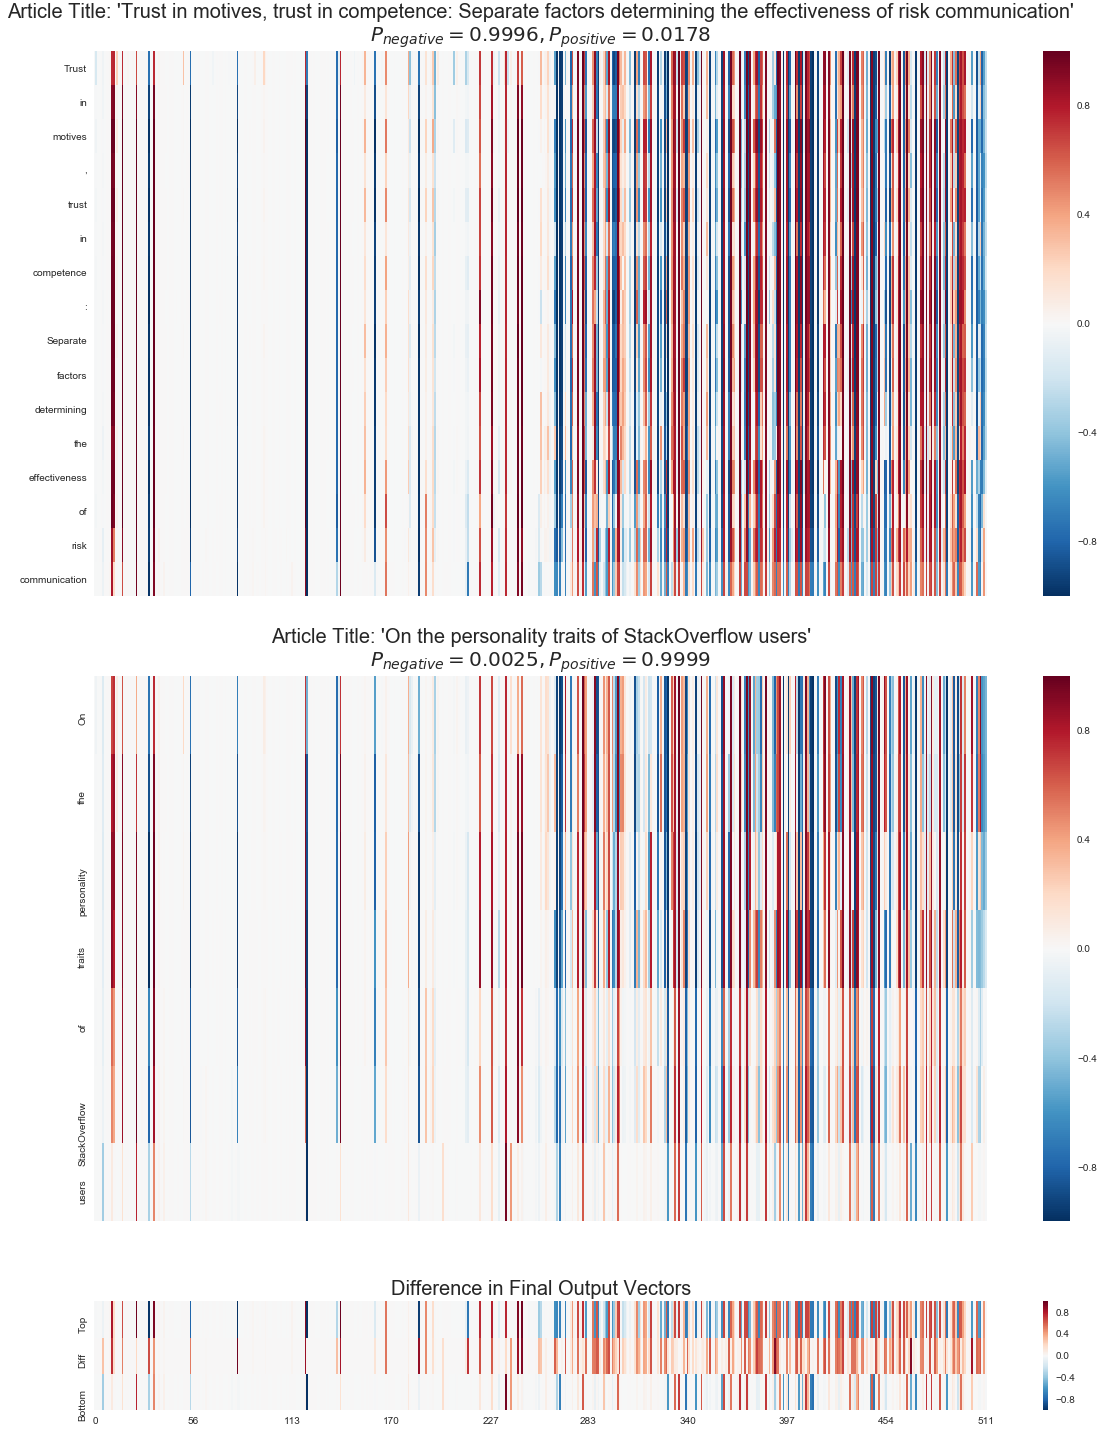

In [71]:
r1 = df_w2v.iloc[-2]
r2 = df_w2v.iloc[1]
compareRows([r1, r2], N, w2v = w2v)
#plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()

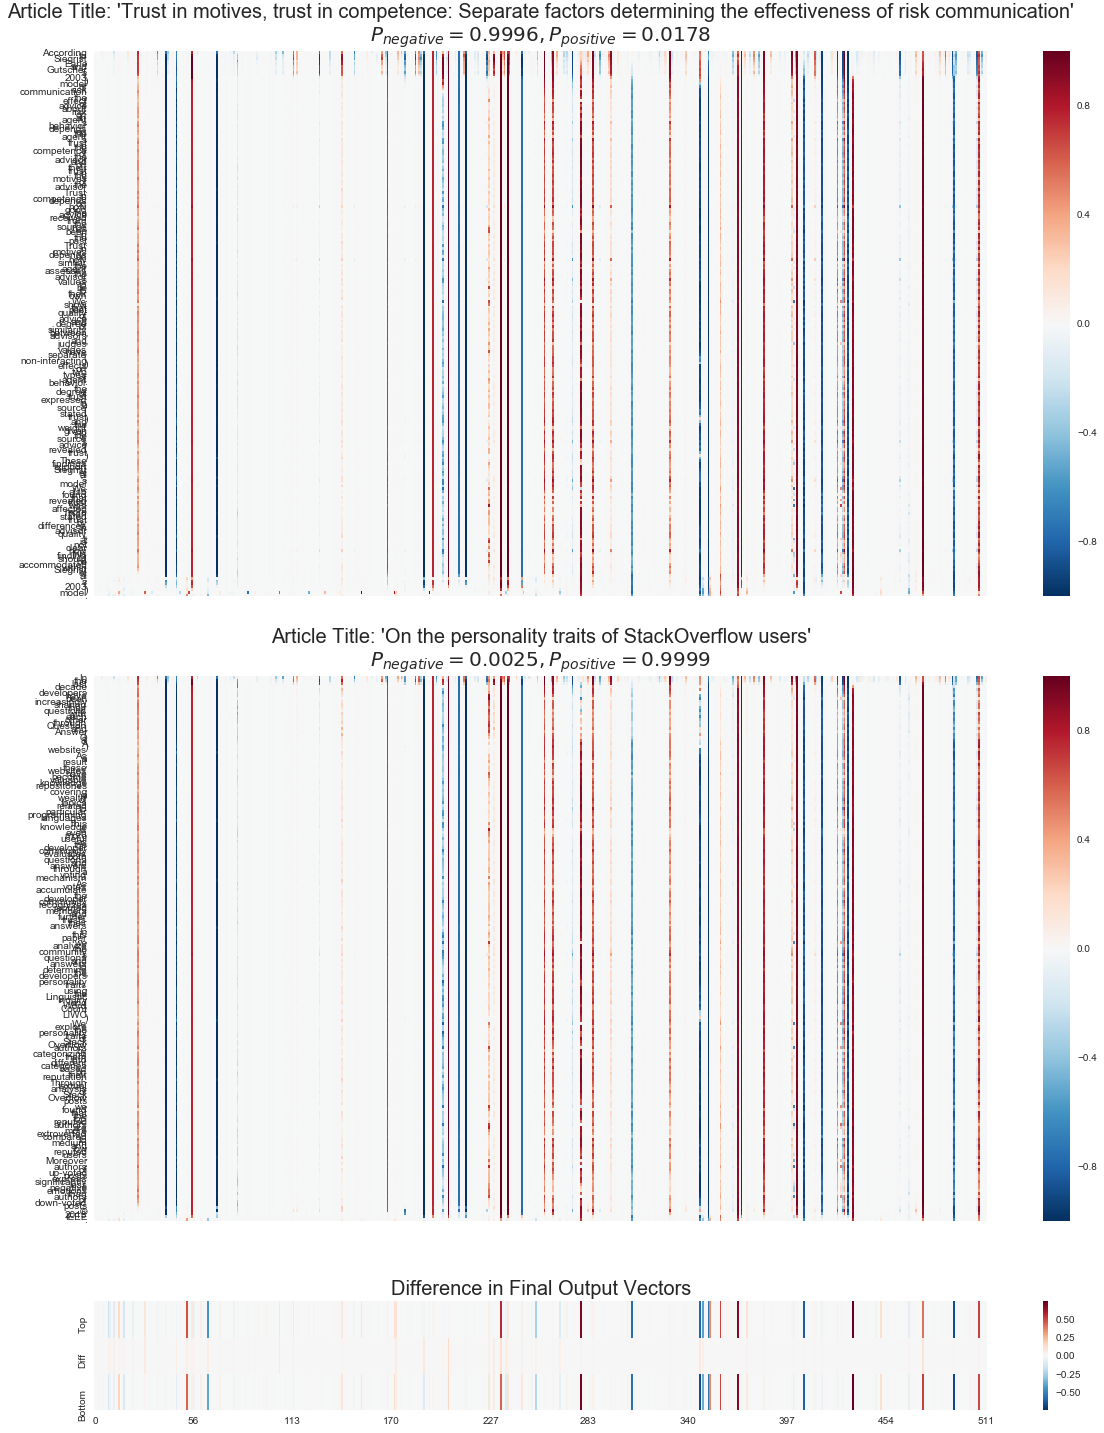

In [72]:
r1 = df_w2v.iloc[-2]
r2 = df_w2v.iloc[1]
compareRows([r1, r2], N, w2v = w2v, useTitle=False)
#plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()